In [25]:
import numpy as np
import glob2
import matplotlib.pyplot as plt
import os
import json
import itertools
import pandas as pd
import seaborn as sns

In [159]:
# Four params and their values, each is a np array
queen_bee_concentrations = np.linspace(0.01, 0.5, 4)
worker_bee_concentrations = np.linspace(0.005, 0.5, 4)
diffusion_coefficients = np.linspace(0.05, 0.5, 4)
worker_bee_thresholds = np.linspace(0.001, 0.005, 4)

In [184]:
# Get names of the 256 json's
json_list = list(map(lambda x : x.split("/")[-1], glob2.glob("avg_distance_data/*.json")))
json_list

['Q0.01_W0.005_D0.05_T0.001.json',
 'Q0.01_W0.005_D0.05_T0.002333333333333333.json',
 'Q0.01_W0.005_D0.05_T0.0036666666666666666.json',
 'Q0.01_W0.005_D0.05_T0.005.json',
 'Q0.01_W0.005_D0.2_T0.001.json',
 'Q0.01_W0.005_D0.2_T0.002333333333333333.json',
 'Q0.01_W0.005_D0.2_T0.0036666666666666666.json',
 'Q0.01_W0.005_D0.2_T0.005.json',
 'Q0.01_W0.005_D0.35_T0.001.json',
 'Q0.01_W0.005_D0.35_T0.002333333333333333.json',
 'Q0.01_W0.005_D0.35_T0.0036666666666666666.json',
 'Q0.01_W0.005_D0.35_T0.005.json',
 'Q0.01_W0.005_D0.5_T0.001.json',
 'Q0.01_W0.005_D0.5_T0.002333333333333333.json',
 'Q0.01_W0.005_D0.5_T0.0036666666666666666.json',
 'Q0.01_W0.005_D0.5_T0.005.json',
 'Q0.01_W0.17_D0.05_T0.001.json',
 'Q0.01_W0.17_D0.05_T0.002333333333333333.json',
 'Q0.01_W0.17_D0.05_T0.0036666666666666666.json',
 'Q0.01_W0.17_D0.05_T0.005.json',
 'Q0.01_W0.17_D0.2_T0.001.json',
 'Q0.01_W0.17_D0.2_T0.002333333333333333.json',
 'Q0.01_W0.17_D0.2_T0.0036666666666666666.json',
 'Q0.01_W0.17_D0.2_T0.005.j

In [160]:
def get_matching_filenames(json_list, param_1, param_2, value_1, value_2):
    matching_json_names = []
    for i in range(len(json_list)):
        if (json_list[i].find(param_1+str(value_1)) != -1) and (json_list[i].find(param_2+str(value_2)) != -1):
            matching_json_names.append(json_list[i])
    
    return matching_json_names

In [8]:
# # Test above function on 1 set of param pair values
# names = get_matching_filenames(json_list, "Q", "W", 0.01, 0.005)
# print(names)

In [194]:
def get_ending_distances(json_file):
    # Get the 10 ending values of a single json
    with open("avg_distance_data/" + json_file, "r") as f:
        data = json.load(f)
        # print(data)
        
    # For 1 JSON of 10 replicate swarms: going through its 10 lists
    dist_list = []
    for i in range(len(data)):
        ending_dist = data[i][-1]
        dist_list.append(ending_dist)
        
    dist_avg = np.median(dist_list)
    dist_var = np.var(dist_list)
    
    return dist_avg, dist_var

In [196]:
# Testing above function
x = get_ending_distances("Q0.01_W0.5_D0.05_T0.001.json")
print(x)

(3.2352874738988193, 0.05203029797825346)


In [220]:
def get_mean_var(json_list, param_1, param_2, value_1, value_2):

    # Load in a json list and get ending value of each list, then average and variance those 160 values
    
#     param_pair_distances = []
    # print(len(param_pair_distances))
    # print(param_pair_distances[0])

    averages = []
    variances = []
    
    names = get_matching_filenames(json_list, param_1, param_2, value_1, value_2)

    for n in names:
        # print(n)
        distance_tuple = get_ending_distances(n)
        # print(distance_tuple)
        averages.append(distance_tuple[0])
        variances.append(distance_tuple[1])

#     # Merge lists in param_pair_distances
#     merged = list(itertools.chain.from_iterable(param_pair_distances))
#     # print(merged)
#     merged_mean = np.mean(merged)
#     # print(merged_mean)
#     merged_var = np.var(merged)
#     # print(merged_var)
    
#     return merged_mean, merged_var
    return np.median(averages), np.median(variances)


In [221]:
# Test above function
get_mean_var(json_list, "Q", "W", 0.01, 0.5)

(3.8353383151660907, 0.0364580586740878)

In [222]:
get_mean_var(json_list, "Q", "W", 0.5, 0.005)

(0.026243124397164655, 9.92695974773759e-06)

In [233]:
# Iterate through different pairs of params and their values

def compare_params(json_list, param_1, param_2, list_1, value_2):
    # Create one column for a W values against 4 queen values
    all_averages = []
    all_variances = []
    for item in list_1:
        # print(item)
        mean_var = get_mean_var(json_list, param_1, param_2, item, value_2)
        # print(mean_var)
        all_averages.append(mean_var[0])
        all_variances.append(mean_var[1]) 
        
    return all_averages, all_variances

In [234]:
# Test
compare_params(json_list, "Q", "W", queen_bee_concentrations, 0.005)
# test_variances = compare_params(json_list, "Q", "W", queen_bee_concentrations, 0.005)
# test_means

([2.5254249091788092,
  0.028011907934131157,
  0.025913910054951205,
  0.026243124397164655],
 [0.39821232293201037,
  1.233051424053944e-05,
  8.204051649229273e-06,
  9.92695974773759e-06])

## Returning DF 

In [457]:
def get_dataframe(json_list, param_1, list_1, param_2, list_2, avg_or_var, index_array):
    
    # Get 4 lists of values contained in cumulative list
    vals_list = []
    for val in list_2:
        if avg_or_var == "avg":
            x = compare_params(json_list, param_1, param_2, list_1, val)[0]
            vals_list.append(x)
        elif avg_or_var == "var":
            x = compare_params(json_list, param_1, param_2, list_1, val)[1]
            vals_list.append(x)
        
    # Turn into dict
    data = {}
    for i, key in enumerate(list_2):
        if len(str(key)) >= 5:
            key = "{0:.3f}".format(key)
            # print(key, type(key))
            data[key] = vals_list[i]
        else:
            # print(key, type(key))
            data[key] = vals_list[i]
            
    # Turn into dataframe 
    df = pd.DataFrame(data, index=[index_array])

    return df


In [445]:
diffusion_coefficients

array([0.05, 0.2 , 0.35, 0.5 ])

In [442]:
queen_bee_concentrations

array([0.01      , 0.17333333, 0.33666667, 0.5       ])

In [453]:
worker_bee_concentrations

array([0.005, 0.17 , 0.335, 0.5  ])

### Queen vs Worker

In [458]:
Q_W_avg_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "W", worker_bee_concentrations, "avg", [0.01, 0.173, 0.34, 0.5])
print("Q_W_avg_df:")
print(Q_W_avg_df)
print("\n")

Q_W_var_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "W", worker_bee_concentrations, "var", [0.01, 0.173, 0.34, 0.5])
print("Q_W_var_df:")
print(Q_W_var_df)
print("\n")

Q_W_avg_df:
          0.005      0.17     0.335       0.5
0.010  2.525425  3.859860  3.865905  3.835338
0.173  0.028012  3.349665  3.650892  3.654042
0.340  0.025914  3.011686  3.332751  3.615352
0.500  0.026243  1.662977  3.123175  3.200595


Q_W_var_df:
          0.005      0.17     0.335       0.5
0.010  0.398212  0.030516  0.038785  0.036458
0.173  0.000012  0.148303  0.079385  0.060472
0.340  0.000008  0.569134  0.500768  0.081253
0.500  0.000010  0.041363  0.407682  0.266727




### Queen vs Coefficient

In [459]:
Q_D_avg_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "D", diffusion_coefficients, "avg", [0.01, 0.173, 0.34, 0.5])
print("Q_D_avg_df:")
print(Q_D_avg_df)
print("\n")

Q_D_var_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "D", diffusion_coefficients, "var", [0.01, 0.173, 0.34, 0.5])
print("Q_D_var_df:")
print(Q_D_var_df)
print("\n")

Q_D_avg_df:
           0.05      0.20      0.35      0.50
0.010  3.106849  3.735799  3.905062  3.882036
0.173  3.142421  3.591160  3.645316  3.461573
0.340  3.131325  3.298570  3.155013  1.177263
0.500  3.116614  3.156698  1.097040  0.137447


Q_D_var_df:
           0.05      0.20      0.35      0.50
0.010  0.016294  0.070096  0.054466  0.048480
0.173  0.018353  0.083909  0.079821  0.111953
0.340  0.012513  0.102129  0.819866  0.458033
0.500  0.018587  0.119016  0.636219  0.222189




### Queen vs Threshold

In [467]:
Q_T_avg_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "T", worker_bee_thresholds, "avg", [0.01, 0.173, 0.34, 0.5])
print("Q_T_avg_df:")
print(Q_T_avg_df)
print("\n")

Q_T_var_df = get_dataframe(json_list, "Q", queen_bee_concentrations, "T", worker_bee_thresholds, "var", [0.01, 0.173, 0.34, 0.5])
print("Q_T_var_df:")
print(Q_T_var_df)
print("\n")

Q_T_avg_df:
          0.001     0.002     0.004     0.005
0.010  3.711758  3.782708  3.535683  3.789805
0.173  3.428152  3.170949  3.416444  3.278126
0.340  3.143548  3.077870  3.140589  3.146925
0.500  2.781754  3.097487  2.874640  2.858763


Q_T_var_df:
          0.001     0.002     0.004     0.005
0.010  0.060354  0.033244  0.039131  0.030516
0.173  0.060472  0.058044  0.047531  0.084503
0.340  0.168907  0.087852  0.052866  0.093095
0.500  0.027985  0.107092  0.081642  0.098573




### Worker vs Coefficient

In [468]:
W_D_avg_df = get_dataframe(json_list, "W", worker_bee_concentrations, "D", diffusion_coefficients, "avg", worker_bee_concentrations)
print("W_D_avg_df:")
print(W_D_avg_df)
print("\n")

W_D_var_df = get_dataframe(json_list, "W", worker_bee_concentrations, "D", diffusion_coefficients, "var", worker_bee_concentrations)
print("W_D_var_df:")
print(W_D_var_df)
print("\n")

W_D_avg_df:
           0.05      0.20      0.35      0.50
0.005  2.904538  0.029596  0.024997  0.023676
0.170  3.136500  3.347989  3.105691  1.053627
0.335  3.142420  3.606829  3.687334  3.582344
0.500  3.145712  3.600451  3.705758  3.735837


W_D_var_df:
           0.05      0.20      0.35      0.50
0.005  0.048468  0.000083  0.000006  0.000007
0.170  0.019408  0.205087  0.736882  0.111610
0.335  0.013401  0.119016  0.333397  0.592269
0.500  0.014222  0.070525  0.086153  0.114509




### Worker vs Threshold

In [471]:
W_T_avg_df = get_dataframe(json_list, "W", worker_bee_concentrations, "T", worker_bee_thresholds, "avg", worker_bee_concentrations)
print("W_T_avg_df:")
print(W_T_avg_df)
print("\n")

W_T_var_df = get_dataframe(json_list, "W", worker_bee_concentrations, "T", worker_bee_thresholds, "var", worker_bee_concentrations)
print("W_T_var_df:")
print(W_T_var_df)
print("\n")

W_T_avg_df:
          0.001     0.002     0.004     0.005
0.005  0.029917  0.028595  0.029957  0.031469
0.170  3.193632  3.119378  3.132969  3.111710
0.335  3.236500  3.413888  3.581041  3.519317
0.500  3.574158  3.640393  3.461084  3.615174


W_T_var_df:
          0.001     0.002     0.004     0.005
0.005  0.000011  0.000187  0.002773  0.000926
0.170  0.086663  0.081757  0.102210  0.063141
0.335  0.081242  0.075103  0.106261  0.082680
0.500  0.069828  0.081253  0.041992  0.074683




### Coefficient vs Threshold

In [473]:
D_T_avg_df = get_dataframe(json_list, "D", diffusion_coefficients, "T", worker_bee_thresholds, "avg", diffusion_coefficients)
print("D_T_avg_df:")
print(D_T_avg_df)
print("\n")

D_T_var_df = get_dataframe(json_list, "D", diffusion_coefficients, "T", worker_bee_thresholds, "var", diffusion_coefficients)
print("D_T_var_df:")
print(D_T_var_df)
print("\n")

D_T_avg_df:
         0.001     0.002     0.004     0.005
0.05  3.151561  3.132250  3.111934  3.099294
0.20  3.259706  3.478785  3.461084  3.513335
0.35  3.247182  3.310853  3.201913  3.473479
0.50  2.941185  2.668873  2.989420  2.304093


D_T_var_df:
         0.001     0.002     0.004     0.005
0.05  0.014164  0.017640  0.013502  0.019674
0.20  0.097638  0.083909  0.081070  0.080198
0.35  0.068376  0.222312  0.074597  0.102328
0.50  0.109764  0.066778  0.081996  0.088420




## Plotting heatmap from dataframe for a pair of params

In [430]:
def plot_heatmap(df_avg, df_var, x_label, y_label, filename):
    
    sns.set(font_scale = 1.5)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(14,4))
    
    sns.heatmap(df_avg, cmap="Greens", cbar_kws={'label': 'Average distance'}, ax=ax1)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_title('Average distance from queen')
    
    sns.heatmap(df_var, cmap="Blues", cbar_kws={'label': 'Variance distance'}, ax=ax2)
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)
    ax2.set_title('Variance distance from queen')

    ax1.invert_yaxis()
    ax2.invert_yaxis()
    
    # ax1.set_xticks(x_ticks)

    # fig.text(0.5, -0., x_label, ha='center', va='center')
    # fig.text(-0.02, -0.1, y_label, ha='center', va='center')
    
    plt.gcf().subplots_adjust(bottom=0.15)
    # plt.title(plot_title)
    plt.savefig('figures/param_heatmap/{}.pdf'.format(filename))

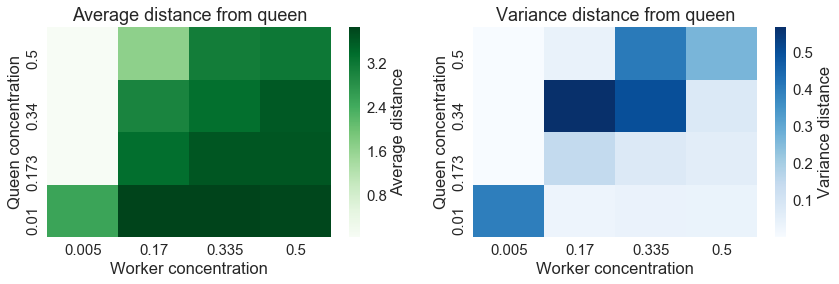

In [462]:
plot_heatmap(Q_W_avg_df, Q_W_var_df, 'Worker concentration', 'Queen concentration', 'Queen_Worker')


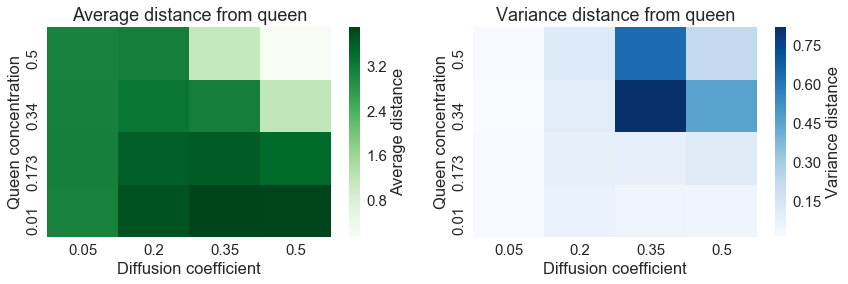

In [463]:
plot_heatmap(Q_D_avg_df, Q_D_var_df, 'Diffusion coefficient', 'Queen concentration', 'Queen_Coefficient')


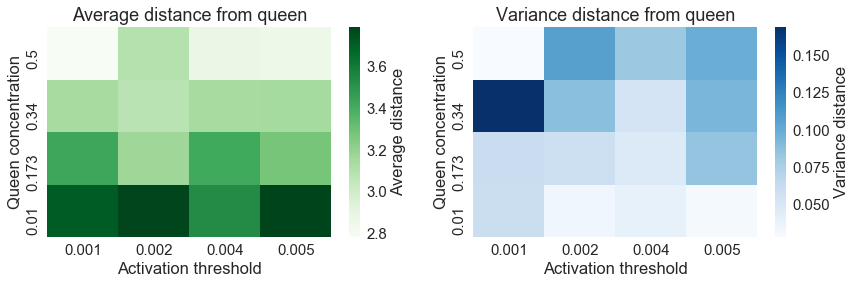

In [465]:
plot_heatmap(Q_T_avg_df, Q_T_var_df, 'Activation threshold', 'Queen concentration', 'Queen_Threshold')


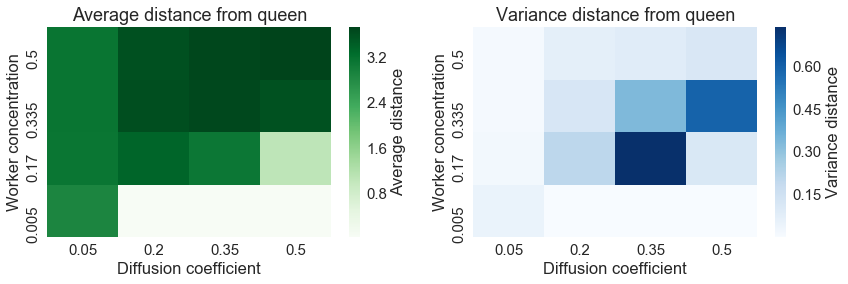

In [469]:
plot_heatmap(W_D_avg_df, W_D_var_df, 'Diffusion coefficient', 'Worker concentration', "Worker_Coefficient")


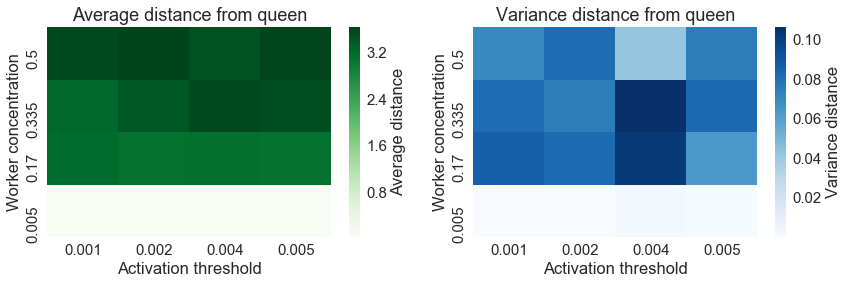

In [472]:
plot_heatmap(W_T_avg_df, W_T_var_df, 'Activation threshold', 'Worker concentration', "Worker_Threshold")


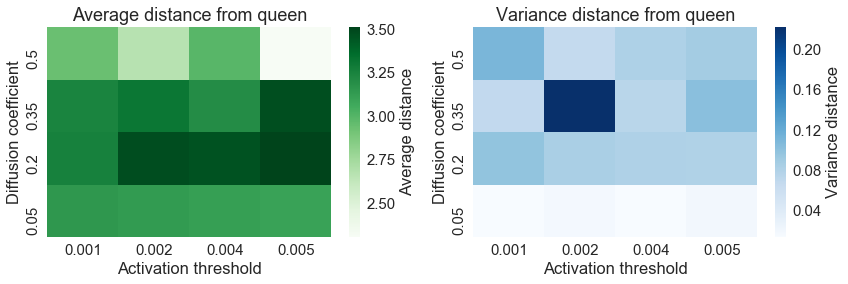

In [474]:
D_T_avg_df
plot_heatmap(D_T_avg_df, D_T_var_df, 'Activation threshold', 'Diffusion coefficient', "Coefficient_Threshold")